In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
     
np.random.seed(42)

In [2]:
# cols = []   ##TODO: Specify desired columns here
df = pd.read_parquet("MSTR_Options_cleaned.parquet", engine="pyarrow")
df

,Timestamp,Stock Price,Symbol,Option Type,Strike Price,Ask Price,Bid Price,Expiration Date
0,2024-08-09,135.370,MSTR240816C00080000,call,80.0,56.35,54.80,2024-08-16
1,2024-08-09,135.370,MSTR240816C00082000,call,82.0,54.45,52.75,2024-08-16
2,2024-08-09,135.370,MSTR240816C00100000,call,100.0,36.30,35.00,2024-08-16
3,2024-08-09,135.370,MSTR240816C00105000,call,105.0,32.15,30.25,2024-08-16
4,2024-08-09,135.370,MSTR240816C00108000,call,108.0,28.85,27.05,2024-08-16
...,...,...,...,...,...,...,...,...
1237115,2025-10-30,253.935,MSTR280121P00420000,put,420.0,208.30,202.40,2028-01-21
1237116,2025-10-30,253.935,MSTR280121P00430000,put,430.0,216.55,210.55,2028-01-21
1237117,2025-10-30,253.935,MSTR280121P00450000,put,450.0,233.00,226.60,2028-01-21
1237118,2025-10-30,253.935,MSTR280121P00470000,put,470.0,249.80,243.60,2028-01-21


## Feature Engineering

In [3]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 1. SETUP
# Ensure 'df' is your raw dataframe
df_calc = df.copy()
df_calc = df_calc.sort_values(['Symbol', 'Timestamp']).reset_index(drop=True)
df_calc['Date'] = df_calc['Timestamp'].dt.date

# --- A. CALCULATE BASE FEATURES (Pre-Imputation) ---

# 1. Structural & Time
# Corrected DTE calculation to be in Years (Total Seconds / Seconds in Year)
df_calc['DTE_yrs'] = (df_calc['Expiration Date'] - df_calc['Timestamp']).dt.total_seconds() / (365.25 * 24 * 3600)
df_calc['Hour'] = df_calc['Timestamp'].dt.hour

# 2. Volatility
df_calc['Rolling_Vol_5d'] = (
    df_calc.groupby('Symbol')['Ask Price']
    .transform(lambda x: x.pct_change().rolling(window=5).std())
)

# 3. Liquidity
df_calc['Spread'] = df_calc['Ask Price'] - df_calc['Bid Price']
df_calc['Mid'] = (df_calc['Ask Price'] + df_calc['Bid Price']) / 2

# Safe division for relative metrics
df_calc['Rel_Spread'] = np.where(df_calc['Mid'] > 0, df_calc['Spread'] / df_calc['Mid'], np.nan)
df_calc['Spread_Pct'] = np.where(df_calc['Ask Price'] > 0, df_calc['Spread'] / df_calc['Ask Price'], np.nan)

# Rolling Spread Stats
grouped_spread = df_calc.groupby('Symbol')['Spread']
df_calc['Spread_RollMean_5'] = grouped_spread.transform(lambda x: x.rolling(5).mean())
df_calc['Spread_RollStd_5'] = grouped_spread.transform(lambda x: x.rolling(5).std())
df_calc['Spread_RollMean_20'] = grouped_spread.transform(lambda x: x.rolling(20).mean())
df_calc['Spread_RollStd_20'] = grouped_spread.transform(lambda x: x.rolling(20).std())

# 4. Market Activity
df_calc['quotes_per_day'] = df_calc.groupby(['Symbol', 'Date'])['Timestamp'].transform('count')
df_calc['avg_quotes_per_day'] = df_calc.groupby('Symbol')['quotes_per_day'].transform('mean')
df_calc['Seconds_Since_Prev'] = df_calc.groupby('Symbol')['Timestamp'].diff().dt.total_seconds()

df_calc['SecondsSincePrev_RollMedian_5'] = (
    df_calc.groupby('Symbol')['Seconds_Since_Prev']
    .transform(lambda x: x.rolling(5, min_periods=1).median())
)

df_calc['Quotes_per_24h_est'] = np.where(
    df_calc['Seconds_Since_Prev'] > 0, 
    86400 / df_calc['Seconds_Since_Prev'], 
    np.nan
)

In [4]:

imputation_map = {
    'Rolling_Vol_5d': 'Rolling_Vol_5d_iter_imputed',
    'Spread_RollStd_5': 'Spread_RollStd_5_iter_imputed',
    'Spread_RollStd_20': 'Spread_RollStd_20_iter_imputed',
    'Spread_RollMean_5': 'Spread_RollMean_5_iter_imputed',
    'Spread_RollMean_20': 'Spread_RollMean_20_iter_imputed',
    'Spread': 'Spread_iter_imputed',
    'Rel_Spread': 'Rel_Spread_iter_imputed',
    'Spread_Pct': 'Spread_Pct_iter_imputed',
    'Mid': 'Mid_iter_imputed',
    'quotes_per_day': 'quotes_per_day_iter_imputed',
    'avg_quotes_per_day': 'avg_quotes_per_day_iter_imputed',
    'Quotes_per_24h_est': 'Quotes_per_24h_est_iter_imputed',
    'Seconds_Since_Prev': 'Seconds_Since_Prev_iter_imputed',
    'SecondsSincePrev_RollMedian_5': 'SecondsSincePrev_RollMedian_5_iter_imputed',
    'DTE_yrs': 'DTE_yrs_iter_imputed',
    'Strike Price': 'Strike Price_iter_imputed',
    'Stock Price': 'Stock Price_iter_imputed',
    'Hour': 'Hour_iter_imputed'
}

raw_features = list(imputation_map.keys())

# 1. Handle Infinite Values
df_calc[raw_features] = df_calc[raw_features].replace([np.inf, -np.inf], np.nan)

# 2. Imputation Step 1: Forward Fill
df_calc[raw_features] = df_calc.groupby('Symbol')[raw_features].ffill()

# 3. Imputation Step 2: Iterative Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_data = imputer.fit_transform(df_calc[raw_features])

# --- C. CONSTRUCT & RESTORE ---

df_imputed_result = pd.DataFrame(
    imputed_data, 
    columns=[imputation_map[c] for c in raw_features], 
    index=df_calc.index
)

# *** CRITICAL STEP: Restore Symbol Column ***
df_imputed_result['Symbol'] = df_calc['Symbol']

# --- D. POST-IMPUTATION CALCULATIONS ---

# 1. Restore raw names for Stock Price
df_imputed_result['Stock Price'] = df_imputed_result['Stock Price_iter_imputed']

# 2. Recalculate Moneyness
df_imputed_result['Moneyness'] = (
    df_imputed_result['Stock Price_iter_imputed'] / 
    df_imputed_result['Strike Price_iter_imputed']
)
df_imputed_result['Moneyness'] = df_imputed_result['Moneyness'].fillna(0)

# --- E. SCALING BY SYMBOL (MODIFIED) ---

high_signal_regime_features = [
    # ... (Your original list) ...
    'Rolling_Vol_5d_iter_imputed', 'Spread_RollStd_5_iter_imputed', 
    'Spread_RollStd_20_iter_imputed', 'Spread_RollMean_5_iter_imputed', 
    'Spread_RollMean_20_iter_imputed', 'Spread_iter_imputed', 
    'Rel_Spread_iter_imputed', 'Spread_Pct_iter_imputed', 
    'Mid_iter_imputed', 'quotes_per_day_iter_imputed', 
    'avg_quotes_per_day_iter_imputed', 'Quotes_per_24h_est_iter_imputed', 
    'Seconds_Since_Prev_iter_imputed', 'SecondsSincePrev_RollMedian_5_iter_imputed', 
    'Moneyness', 'DTE_yrs_iter_imputed', 'Strike Price_iter_imputed', 
    'Stock Price', 'Hour_iter_imputed'
]

# Additional Meta Features
df_imputed_result['Liquidity_Stress_Index'] = (
    df_imputed_result['Rel_Spread_iter_imputed'].rank(pct=True) +
    df_imputed_result['Spread_RollStd_20_iter_imputed'].rank(pct=True)
)
df_imputed_result['Activity_Intensity'] = (
    df_imputed_result['quotes_per_day_iter_imputed'].rank(pct=True) -
    df_imputed_result['Seconds_Since_Prev_iter_imputed'].rank(pct=True)
)
df_imputed_result['Volatility_Shock'] = (
    df_imputed_result['Rolling_Vol_5d_iter_imputed'].rank(pct=True) -
    df_imputed_result['Spread_RollMean_5_iter_imputed'].rank(pct=True)
)

high_signal_regime_features += ['Liquidity_Stress_Index', 'Activity_Intensity', 'Volatility_Shock']

# Final Selection
df_final = df_imputed_result[['Symbol'] + high_signal_regime_features].copy()

In [5]:
# --- SCALER CONFIGURATION ---
# Choose: 'standard' (Z-score), 'robust' (IQR), or 'minmax' (0-1)
SCALER_TYPE = 'minmax' 

print(f"Scaling features by Symbol using [{SCALER_TYPE.upper()}] scaler...")

def get_scaler_func(x, method='standard'):
    """Returns scaled values based on the selected method."""
    if method == 'standard':
        # Z-score: (x - mean) / std
        std = x.std(ddof=0)
        return np.zeros_like(x) if std == 0 else (x - x.mean()) / std
        
    elif method == 'robust':
        # Robust: (x - median) / (q75 - q25)
        q25 = x.quantile(0.25)
        q75 = x.quantile(0.75)
        iqr = q75 - q25
        median = x.median()
        return np.zeros_like(x) if iqr == 0 else (x - median) / iqr
        
    elif method == 'minmax':
        # MinMax: (x - min) / (max - min)
        min_val = x.min()
        max_val = x.max()
        rng = max_val - min_val
        return np.zeros_like(x) if rng == 0 else (x - min_val) / rng
    
    else:
        raise ValueError(f"Unknown scaler type: {method}")  

# Apply the selected scaler per Symbol group
df_final_scaled = df_final.copy()   # keep df_final unmodified

df_final_scaled[high_signal_regime_features] = (
    df_final_scaled.groupby('Symbol')[high_signal_regime_features]
    .transform(lambda x: get_scaler_func(x, method=SCALER_TYPE))
)

# Fill any remaining NaNs from scaling (e.g. single-row groups or constant values)
df_final_scaled[high_signal_regime_features] = df_final_scaled[high_signal_regime_features].fillna(0)

print("Final Columns:", df_final_scaled.columns.tolist())
print(df_final_scaled.info())

Scaling features by Symbol using [MINMAX] scaler...
Final Columns: ['Symbol', 'Rolling_Vol_5d_iter_imputed', 'Spread_RollStd_5_iter_imputed', 'Spread_RollStd_20_iter_imputed', 'Spread_RollMean_5_iter_imputed', 'Spread_RollMean_20_iter_imputed', 'Spread_iter_imputed', 'Rel_Spread_iter_imputed', 'Spread_Pct_iter_imputed', 'Mid_iter_imputed', 'quotes_per_day_iter_imputed', 'avg_quotes_per_day_iter_imputed', 'Quotes_per_24h_est_iter_imputed', 'Seconds_Since_Prev_iter_imputed', 'SecondsSincePrev_RollMedian_5_iter_imputed', 'Moneyness', 'DTE_yrs_iter_imputed', 'Strike Price_iter_imputed', 'Stock Price', 'Hour_iter_imputed', 'Liquidity_Stress_Index', 'Activity_Intensity', 'Volatility_Shock']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161031 entries, 0 to 1161030
Data columns (total 23 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   Symbol                                

In [6]:
df_final

,Symbol,Rolling_Vol_5d_iter_imputed,Spread_RollStd_5_iter_imputed,Spread_RollStd_20_iter_imputed,Spread_RollMean_5_iter_imputed,Spread_RollMean_20_iter_imputed,Spread_iter_imputed,Rel_Spread_iter_imputed,Spread_Pct_iter_imputed,Mid_iter_imputed,...,Seconds_Since_Prev_iter_imputed,SecondsSincePrev_RollMedian_5_iter_imputed,Moneyness,DTE_yrs_iter_imputed,Strike Price_iter_imputed,Stock Price,Hour_iter_imputed,Liquidity_Stress_Index,Activity_Intensity,Volatility_Shock
0,MSTR240816C00075000,0.260664,0.951475,1.065374,2.218701,1.851578,2.80,0.050000,0.048780,56.000,...,142908.033244,114335.082979,1.805067,0.008214,75.0,135.380,0.0,0.928229,-0.245055,0.250346
1,MSTR240816C00075000,0.273168,1.099452,1.103527,2.953779,2.312370,4.10,0.070629,0.068220,58.050,...,86400.000000,86400.000000,1.738267,0.005476,75.0,130.370,0.0,1.055310,0.112603,0.171028
2,MSTR240816C00078000,0.282565,1.183467,1.221473,3.471813,2.762080,4.75,0.087196,0.083553,54.475,...,136667.368414,116414.000775,1.735641,0.008214,78.0,135.380,0.0,1.158070,-0.243252,0.127063
3,MSTR240816C00078000,0.271234,1.039330,1.054098,2.638149,2.065211,3.65,0.067561,0.065354,54.025,...,86400.000000,86400.000000,1.671410,0.005476,78.0,130.370,0.0,1.020765,0.112603,0.207692
4,MSTR240816C00080000,0.247157,0.804390,0.968894,1.420437,1.279178,1.55,0.027890,0.027507,55.575,...,147136.591758,113084.087732,1.692125,0.019165,80.0,135.370,0.0,0.696849,-0.247392,0.366386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161026,MSTR280121P00600000,0.061101,4.803957,4.683202,10.890000,11.266668,7.15,0.023592,0.023316,303.075,...,86400.000000,86400.000000,0.552000,2.286105,600.0,331.200,0.0,1.217586,0.112603,-0.680300
1161027,MSTR280121P00600000,0.059840,3.819097,4.094551,9.310000,10.081125,8.30,0.026817,0.026463,309.500,...,86400.000000,86400.000000,0.534192,2.283368,600.0,320.515,0.0,1.227207,0.112603,-0.664705
1161028,MSTR280121P00620000,-0.087170,2.172725,3.376965,8.262224,9.540645,6.65,0.022291,0.022045,298.325,...,193494.862036,104884.540298,0.580153,2.291581,620.0,359.695,0.0,1.114197,-0.281529,-0.897145
1161029,MSTR280121P00620000,-0.052201,2.772658,3.778408,11.277769,11.770570,11.20,0.034945,0.034345,320.500,...,86400.000000,86400.000000,0.530323,2.288843,620.0,328.800,0.0,1.286206,0.112603,-0.940497


- cluster exploration
- experiment w deep learning approach and autoregressive forecasting models on each cluster
- email to swirlbeast@gmail.com for use on GPU machine

# Finding Optimal K for K-Means Clustering

Saved subsample indices to kmeans_cv_subsample_indices_20251121_121044.npy (used_subsample=True)
Running K-Means KFold-CV on 25000 sample points (full_size=1161031)...
k=2: CV Silhouette=0.1933±0.0029 | CV Inertia=2950±48
k=2: CV Silhouette=0.1933±0.0029 | CV Inertia=2950±48
k=3: CV Silhouette=0.1765±0.0023 | CV Inertia=2633±41
k=3: CV Silhouette=0.1765±0.0023 | CV Inertia=2633±41
k=4: CV Silhouette=0.1544±0.0033 | CV Inertia=2475±39
k=4: CV Silhouette=0.1544±0.0033 | CV Inertia=2475±39
k=5: CV Silhouette=0.1334±0.0072 | CV Inertia=2336±37
k=5: CV Silhouette=0.1334±0.0072 | CV Inertia=2336±37
k=6: CV Silhouette=0.1338±0.0036 | CV Inertia=2214±38
k=6: CV Silhouette=0.1338±0.0036 | CV Inertia=2214±38
k=7: CV Silhouette=0.1223±0.0036 | CV Inertia=2110±35
k=7: CV Silhouette=0.1223±0.0036 | CV Inertia=2110±35
k=8: CV Silhouette=0.1274±0.0029 | CV Inertia=2036±36
k=8: CV Silhouette=0.1274±0.0029 | CV Inertia=2036±36
k=9: CV Silhouette=0.1223±0.0069 | CV Inertia=1978±37
k=9: CV Silhouette=0.1

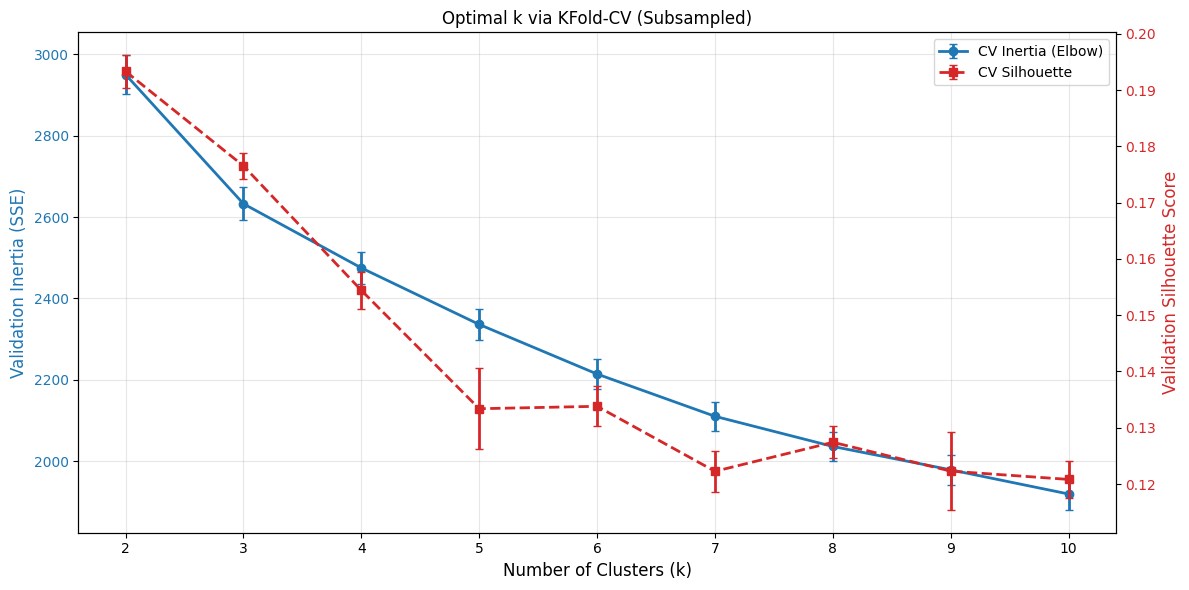

Saved CV metrics to kmeans_cv_metrics_20251121_121102.csv


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score

# 1. PREPARE DATA
# Use the scaled features from the previous step
X_full = df_final_scaled[high_signal_regime_features].values
full_size = len(X_full)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Subsample for Silhouette & CV speed (O(N^2) silhouette complexity)
# Configuration variables for reproducibility
SAMPLE_SIZE = 30000
SUBSAMPLE_SEED = 42
np.random.seed(SUBSAMPLE_SEED)
if full_size > SAMPLE_SIZE:
    subsample_idx = np.random.choice(full_size, SAMPLE_SIZE, replace=False)
    X_sample = X_full[subsample_idx]
    used_subsample = True
else:
    subsample_idx = np.arange(full_size)
    X_sample = X_full
    used_subsample = False

# Persist subsample indices for reproducibility
from datetime import datetime
ts_sub = datetime.now().strftime('%Y%m%d_%H%M%S')
subsample_indices_path = f'kmeans_cv_subsample_indices_{ts_sub}.npy'
np.save(subsample_indices_path, subsample_idx)
print(f"Saved subsample indices to {subsample_indices_path} (used_subsample={used_subsample})")

# 2. RUN K-FOLD CROSS-VALIDATION OPTIMIZATION LOOP ON SUBSAMPLE
print(f"Running K-Means KFold-CV on {len(X_sample)} sample points (full_size={full_size})...")

k_values = range(2, 21) # Test 2 to 10 clusters
cv_inertia_means = []
cv_inertia_stds = []
cv_silhouette_means = []
cv_silhouette_stds = []

for k in k_values:
    fold_inertias = []
    fold_sils = []
    for train_idx, val_idx in kf.split(X_sample):
        X_tr, X_val = X_sample[train_idx], X_sample[val_idx]
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_tr)
        val_inertia = -kmeans.score(X_val)
        val_labels = kmeans.predict(X_val)
        sil = silhouette_score(X_val, val_labels)
        fold_inertias.append(val_inertia)
        fold_sils.append(sil)
    mean_inertia = float(np.mean(fold_inertias))
    std_inertia = float(np.std(fold_inertias))
    mean_sil = float(np.mean(fold_sils))
    std_sil = float(np.std(fold_sils))
    cv_inertia_means.append(mean_inertia)
    cv_inertia_stds.append(std_inertia)
    cv_silhouette_means.append(mean_sil)
    cv_silhouette_stds.append(std_sil)
    print(f"k={k}: CV Silhouette={mean_sil:.4f}±{std_sil:.4f} | CV Inertia={mean_inertia:.0f}±{std_inertia:.0f}")

# 3. VISUALIZATION (Elbow & Silhouette Plot with CV Means ± Std)
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Validation Inertia (SSE)', color=color, fontsize=12)
ax1.errorbar(list(k_values), cv_inertia_means, yerr=cv_inertia_stds, marker='o', color=color, linewidth=2, capsize=3, label='CV Inertia (Elbow)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Validation Silhouette Score', color=color, fontsize=12)
ax2.errorbar(list(k_values), cv_silhouette_means, yerr=cv_silhouette_stds, marker='s', linestyle='--', color=color, linewidth=2, capsize=3, label='CV Silhouette')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Optimal k via KFold-CV (Subsampled)')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()

# 4. PERSIST CV METRICS (without persisting chosen k)
scaler_type = globals().get('SCALER_TYPE', 'unknown')
metrics_df = pd.DataFrame({
    'k': list(k_values),
    'cv_silhouette_mean': cv_silhouette_means,
    'cv_silhouette_std': cv_silhouette_stds,
    'cv_inertia_mean': cv_inertia_means,
    'cv_inertia_std': cv_inertia_stds,
    'n_splits': [kf.get_n_splits()] * len(list(k_values)),
    'sample_size': [len(X_sample)] * len(list(k_values)),
    'full_size': [full_size] * len(list(k_values)),
    'used_subsample': [used_subsample] * len(list(k_values)),
    'subsample_seed': [SUBSAMPLE_SEED] * len(list(k_values)),
    'subsample_indices_file': [subsample_indices_path] * len(list(k_values)),
    'random_state': [42] * len(list(k_values)),
    'scaler_type': [scaler_type] * len(list(k_values))
,})
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
metrics_path = f'kmeans_cv_metrics_{ts}.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"Saved CV metrics to {metrics_path}")

In [ ]:
# Select k with the highest Cross-Validated Silhouette Score
import numpy as np
try:
    optimal_k = list(k_values)[int(np.nanargmax(cv_silhouette_means))]
except Exception as e:
    print(f"Falling back to k=3 due to: {e}")
    optimal_k = 3

print(f"\n>>> SELECTED OPTIMAL CLUSTERS (CV): k={optimal_k} <<<")

# Label the FULL dataset using the optimal k
print(f"Labeling full dataset ({len(df_final)} rows)...")
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_final['Cluster'] = final_kmeans.fit_predict(X_full)

# 5. INSPECT RESULTS
print("\n--- Cluster Counts ---")
print(df_final['Cluster'].value_counts().sort_index())

print("\n--- Regime Profiles (Mean Z-Scores) ---")
# Show what each cluster represents physically
print(df_final.groupby('Cluster')[high_signal_regime_features].mean().T.round(2))


>>> SELECTED OPTIMAL CLUSTERS: k=3 <<<
Labeling full dataset (1161031 rows)...

--- Cluster Counts ---
Cluster
0    241901
1    561961
2    357169
Name: count, dtype: int64

--- Regime Profiles (Mean Z-Scores) ---
Cluster                                        0     1     2
Rolling_Vol_5d_iter_imputed                 0.32  0.32  0.36
Spread_RollStd_5_iter_imputed               0.23  0.14  0.48
Spread_RollStd_20_iter_imputed              0.36  0.24  0.65
Spread_RollMean_5_iter_imputed              0.23  0.15  0.61
Spread_RollMean_20_iter_imputed             0.27  0.16  0.63
Spread_iter_imputed                         0.20  0.18  0.53
Rel_Spread_iter_imputed                     0.23  0.25  0.39
Spread_Pct_iter_imputed                     0.26  0.29  0.41
Mid_iter_imputed                            0.29  0.25  0.55
quotes_per_day_iter_imputed                 0.00  0.03  0.03
avg_quotes_per_day_iter_imputed             0.00  0.00  0.00
Quotes_per_24h_est_iter_imputed             0.22  1.0

# Cluster Visualization with Subsampling

Starting Combined Visualization Pipeline with 25000 samples...
Applying Quantile Scaling...
Running K-Means (k=3)...
Calculating 2D Projections...


c:\Users\Saber\Desktop\research\MSTR-Options-Research-SwIRL\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Calculating 3D Projections...


c:\Users\Saber\Desktop\research\MSTR-Options-Research-SwIRL\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Generating Dashboard...


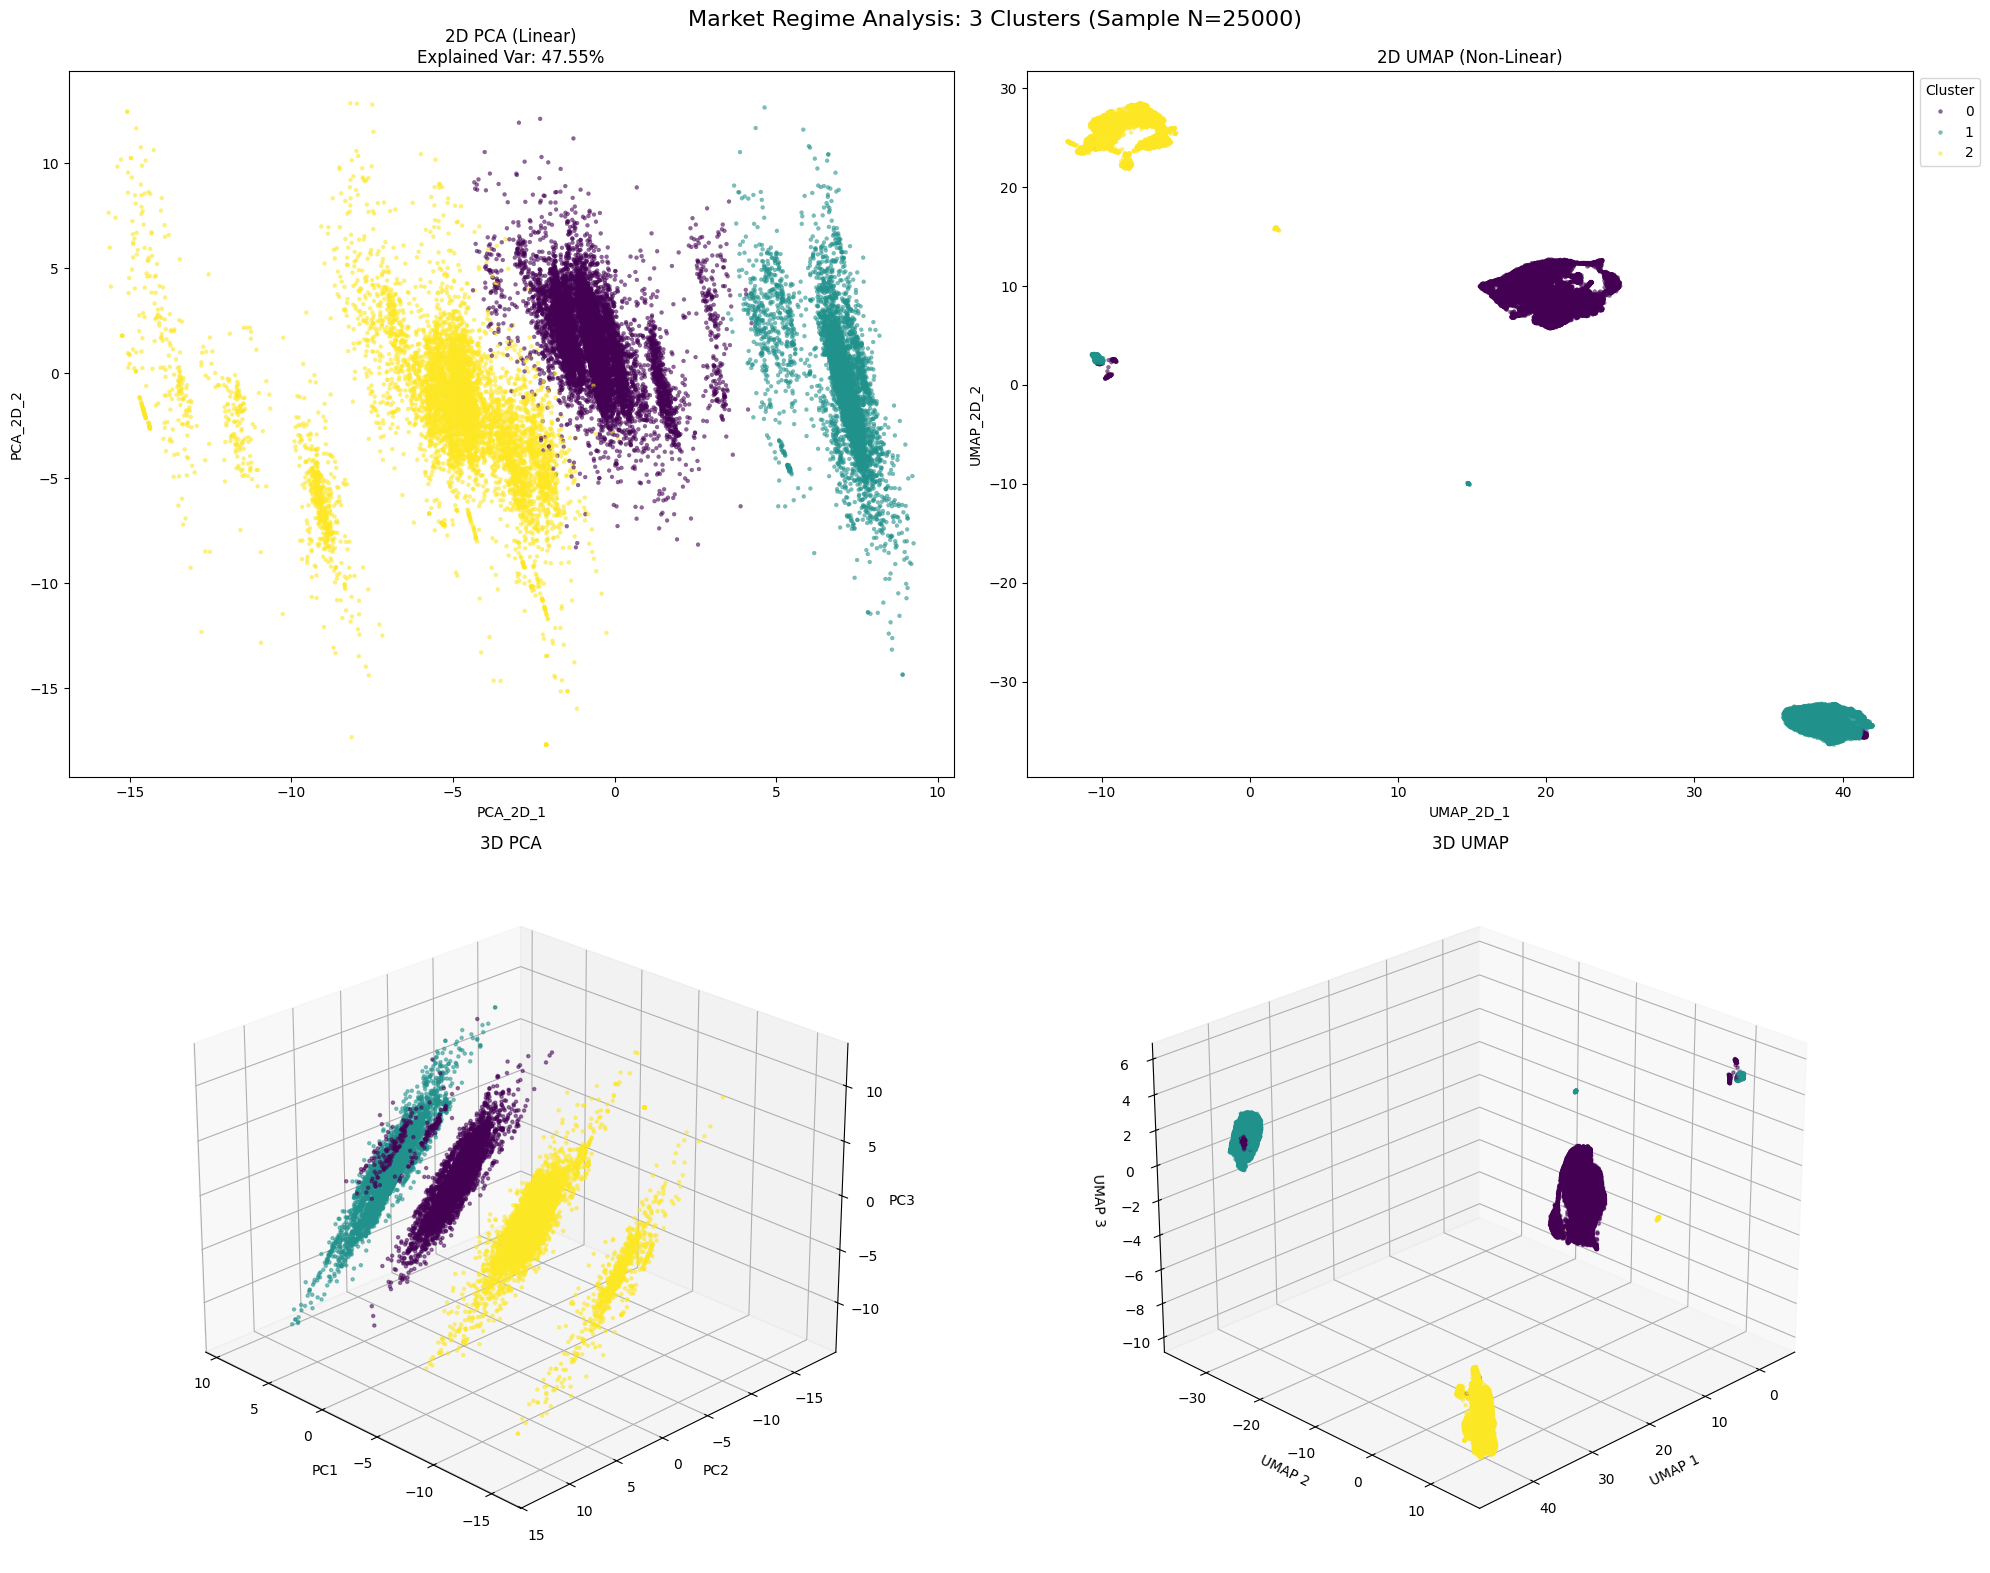

In [259]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import QuantileTransformer

# Check for UMAP installation
try:
    import umap
except ImportError:
    print("UMAP library not found. Installing...")
    import umap

# 1. CONFIGURATION
SAMPLE_SIZE = 25000  
N_CLUSTERS = 3  
RANDOM_STATE = 42

print(f"Starting Combined Visualization Pipeline with {SAMPLE_SIZE} samples...")

# 2. DATA PREPARATION & SCALING
if len(df_final) > SAMPLE_SIZE:
    df_viz = df_final.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE).copy()
else:
    df_viz = df_final.copy()

# Quantile Scaling for visual clarity
print("Applying Quantile Scaling...")
scaler = QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE)
X_viz = scaler.fit_transform(df_viz[high_signal_regime_features])

# 3. CLUSTERING (Ground Truth for Colors)
print(f"Running K-Means (k={N_CLUSTERS})...")
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
df_viz['Cluster'] = kmeans.fit_predict(X_viz)

# 4. CALCULATE PROJECTIONS

# --- 2D Projections ---
print("Calculating 2D Projections...")
pca_2d = PCA(n_components=2)
pca_2d_res = pca_2d.fit_transform(X_viz)
df_viz['PCA_2D_1'] = pca_2d_res[:, 0]
df_viz['PCA_2D_2'] = pca_2d_res[:, 1]

reducer_2d = umap.UMAP(n_neighbors=50, min_dist=0.2, n_components=2, random_state=RANDOM_STATE, n_jobs=-1)
umap_2d_res = reducer_2d.fit_transform(X_viz)
df_viz['UMAP_2D_1'] = umap_2d_res[:, 0]
df_viz['UMAP_2D_2'] = umap_2d_res[:, 1]

# --- 3D Projections ---
print("Calculating 3D Projections...")
pca_3d = PCA(n_components=3)
pca_3d_res = pca_3d.fit_transform(X_viz)
df_viz['PCA_3D_1'] = pca_3d_res[:, 0]
df_viz['PCA_3D_2'] = pca_3d_res[:, 1]
df_viz['PCA_3D_3'] = pca_3d_res[:, 2]

reducer_3d = umap.UMAP(n_neighbors=50, min_dist=0.2, n_components=3, random_state=RANDOM_STATE, n_jobs=-1)
umap_3d_res = reducer_3d.fit_transform(X_viz)
df_viz['UMAP_3D_1'] = umap_3d_res[:, 0]
df_viz['UMAP_3D_2'] = umap_3d_res[:, 1]
df_viz['UMAP_3D_3'] = umap_3d_res[:, 2]

# 5. COMBINED PLOTTING
print("Generating Dashboard...")
fig = plt.figure(figsize=(20, 16))
palette = 'viridis'

# --- Top Left: 2D PCA ---
ax1 = fig.add_subplot(2, 2, 1)
sns.scatterplot(
    data=df_viz, x='PCA_2D_1', y='PCA_2D_2', 
    hue='Cluster', palette=palette, s=8, alpha=0.6, ax=ax1, edgecolor=None, legend=False
)
ax1.set_title(f'2D PCA (Linear)\nExplained Var: {sum(pca_2d.explained_variance_ratio_):.2%}')

# --- Top Right: 2D UMAP ---
ax2 = fig.add_subplot(2, 2, 2)
sns.scatterplot(
    data=df_viz, x='UMAP_2D_1', y='UMAP_2D_2', 
    hue='Cluster', palette=palette, s=8, alpha=0.6, ax=ax2, edgecolor=None, legend='full'
)
ax2.set_title('2D UMAP (Non-Linear)')
# Move legend outside
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

# --- Bottom Left: 3D PCA ---
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
sc3 = ax3.scatter(
    df_viz['PCA_3D_1'], df_viz['PCA_3D_2'], df_viz['PCA_3D_3'],
    c=df_viz['Cluster'], cmap=palette, s=5, alpha=0.5
)
ax3.set_title('3D PCA')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')
ax3.view_init(elev=25, azim=135) # Adjusted angle for better depth perception

# --- Bottom Right: 3D UMAP ---
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
sc4 = ax4.scatter(
    df_viz['UMAP_3D_1'], df_viz['UMAP_3D_2'], df_viz['UMAP_3D_3'],
    c=df_viz['Cluster'], cmap=palette, s=5, alpha=0.5
)
ax4.set_title('3D UMAP')
ax4.set_xlabel('UMAP 1')
ax4.set_ylabel('UMAP 2')
ax4.set_zlabel('UMAP 3')
ax4.view_init(elev=25, azim=45)

plt.suptitle(f"Market Regime Analysis: {N_CLUSTERS} Clusters (Sample N={SAMPLE_SIZE})", fontsize=16)
plt.tight_layout()
plt.show()

# Final Dataset With Cluster Labels

In [257]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans

# 1. CONFIGURATION
# Use the same features and k that gave you the good visualization
N_CLUSTERS = 3 
RANDOM_STATE = 42

print(f"Running Full Regime Analysis on {len(df_final)} rows with k={N_CLUSTERS}...")

# 2. SCALING (Crucial for matching the visualization)
# We use QuantileTransformer to replicate the 'clean' separation from the plots
print("Applying Quantile Scaling to full dataset...")
scaler = QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE)
X_full = scaler.fit_transform(df_final[high_signal_regime_features])

# 3. CLUSTERING
# Fit K-Means on the ENTIRE dataset
print("Fitting K-Means...")
kmeans_full = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=10)

# Assign the 'Cluster' label to your main dataframe
df_final['Cluster'] = kmeans_full.fit_predict(X_full)

# 4. VERIFICATION
# Check the distribution of your new regimes
print("\n--- Final Cluster Counts ---")
print(df_final['Cluster'].value_counts().sort_index())

# Check what these clusters actually mean physically
print("\n--- Regime Profiles (Mean Z-Scores) ---")
print(df_final.groupby('Cluster')[high_signal_regime_features].mean().T.round(2))

print("\nAnalysis Complete. 'Cluster' column added to df_final.")
df_final

Running Full Regime Analysis on 1161031 rows with k=3...
Applying Quantile Scaling to full dataset...
Fitting K-Means...

--- Final Cluster Counts ---
Cluster
0    290568
1    318877
2    551586
Name: count, dtype: int64

--- Regime Profiles (Mean Z-Scores) ---
Cluster                                        0     1     2
Rolling_Vol_5d_iter_imputed                 0.35  0.33  0.32
Spread_RollStd_5_iter_imputed               0.31  0.30  0.22
Spread_RollStd_20_iter_imputed              0.39  0.43  0.37
Spread_RollMean_5_iter_imputed              0.31  0.34  0.29
Spread_RollMean_20_iter_imputed             0.32  0.37  0.31
Spread_iter_imputed                         0.26  0.28  0.31
Rel_Spread_iter_imputed                     0.30  0.26  0.30
Spread_Pct_iter_imputed                     0.33  0.29  0.33
Mid_iter_imputed                            0.34  0.36  0.35
quotes_per_day_iter_imputed                 0.06  0.00  0.02
avg_quotes_per_day_iter_imputed             0.00  0.00  0.00
Quotes

,Symbol,Rolling_Vol_5d_iter_imputed,Spread_RollStd_5_iter_imputed,Spread_RollStd_20_iter_imputed,Spread_RollMean_5_iter_imputed,Spread_RollMean_20_iter_imputed,Spread_iter_imputed,Rel_Spread_iter_imputed,Spread_Pct_iter_imputed,Mid_iter_imputed,...,SecondsSincePrev_RollMedian_5_iter_imputed,Moneyness,DTE_yrs_iter_imputed,Strike Price_iter_imputed,Stock Price,Hour_iter_imputed,Liquidity_Stress_Index,Activity_Intensity,Volatility_Shock,Cluster
0,MSTR240816C00075000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.000000,1.000000,0.0,1.000000,0.0,0.000000,0.000000,1.000000,1
1,MSTR240816C00075000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,1.000000,0.000000,0
2,MSTR240816C00078000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.000000,0.000000,1
3,MSTR240816C00078000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,1.000000,0
4,MSTR240816C00080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.0,0.998004,1.000000,0.0,0.998004,0.0,0.000000,0.383859,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161026,MSTR280121P00600000,0.960694,1.000000,0.750330,0.243077,0.207219,0.084577,0.038671,0.039262,0.649042,...,0.0,0.435966,0.058824,0.0,0.435966,0.0,0.013579,1.000000,0.950369,0
1161027,MSTR280121P00600000,0.949883,0.769907,0.433713,0.000000,0.000000,0.199005,0.139020,0.140919,0.845977,...,0.0,0.224466,0.000000,0.0,0.224466,0.0,0.050285,1.000000,1.000000,0
1161028,MSTR280121P00620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.000000,1.000000,0.0,1.000000,0.0,0.000000,0.000000,1.000000,1
1161029,MSTR280121P00620000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.000000,0.500000,0.0,0.000000,0.0,1.000000,1.000000,0.000000,0


In [ ]:
df

# Model and Data Persistance

In [ ]:
import joblib
from sklearn.pipeline import Pipeline

# 1. Create a Pipeline
# This bundles the preprocessing and modeling steps into one object
regime_pipeline = Pipeline([
    ('scaler', scaler),      # The QuantileTransformer you fitted
    ('kmeans', kmeans_full)  # The KMeans model you fitted
])

# 2. Save the Pipeline to a single file
filename = 'market_regime_model_v1.joblib'
joblib.dump(regime_pipeline, filename)

print(f"Model pipeline saved to {filename}")

# 1. Save to Parquet
# 'compression=snappy' is the default and offers a great balance of speed/size
df_final.to_parquet('clustered_options_data.parquet', index=False)

print("Dataset saved successfully to 'clustered_options_data.parquet'")

Model pipeline saved to market_regime_model_v1.joblib
Dataset saved successfully to 'clustered_options_data.parquet'


In [ ]:
# --- How to Load it Later ---
# df_loaded = pd.read_parquet('clustered_options_data.parquet')

# --- How to Use the Saved Pipeline for Inference ---
# import joblib
# import pandas as pd

# # 1. Load the pipeline
# # (This loads both the scaler logic and the cluster centers)
# pipeline = joblib.load('market_regime_model_v1.joblib')

# # 2. Simulate "New" Live Data
# # Imagine this is a single row of data coming in from the API
# new_data = {
#     'Rolling_Vol_5d_iter_imputed': 0.05,
#     'Spread_RollStd_5_iter_imputed': 1.2, # High spread vol
#     'Spread_RollStd_20_iter_imputed': 1.1,
#     'Spread_RollMean_5_iter_imputed': 2.5, # Wide spread
#     'Spread_RollMean_20_iter_imputed': 2.4,
#     'Spread_iter_imputed': 2.5,
#     'Rel_Spread_iter_imputed': 0.02,
#     'Spread_Pct_iter_imputed': 0.02,
#     'Mid_iter_imputed': 150.0,
#     'quotes_per_day_iter_imputed': 5000,
#     'avg_quotes_per_day_iter_imputed': 5200,
#     'Quotes_per_24h_est_iter_imputed': 8000,
#     'Seconds_Since_Prev_iter_imputed': 0.5,
#     'SecondsSincePrev_RollMedian_5_iter_imputed': 0.4,
#     'Moneyness': 1.0,
#     'DTE_yrs_iter_imputed': 0.1,
#     'Strike Price_iter_imputed': 150,
#     'Stock Price': 150,
#     'Hour_iter_imputed': 10,
#     'Liquidity_Stress_Index': 0.8,  # High stress
#     'Activity_Intensity': 0.2,
#     'Volatility_Shock': 0.1
# }

# # Convert to DataFrame (Must match the columns used during training exactly)
# df_live = pd.DataFrame([new_data])
# features_needed = [
#     # ... Ensure this list matches exactly what you used to train ...
#     'Rolling_Vol_5d_iter_imputed', 'Spread_RollStd_5_iter_imputed', 
#     # ... add all other features here ...
# ]

# # Double check input matches training columns
# X_live = df_live[features_needed] # Ensure correct column order

# # 3. Predict
# # The pipeline automatically runs the Scaler, then the KMeans
# predicted_cluster = pipeline.predict(X_live)[0]

# print(f"Predicted Market Regime: {predicted_cluster}")